## Load data

In [ ]:
from abc import ABC, abstractmethod
from pytrends.request import TrendReq
import yfinance as yf
import pandas as pd
import datetime as dt
from datetime import timedelta, date
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
class extract(ABC):
    def __init__(self, start:str, end:str) -> None:
        self.start = start
        self.end = end
    def connect_API(self) -> None: pass
    @abstractmethod
    def collect_data(self): pass

class gtrend(extract):
    def __init__(self, keyword:str, start:str, end:str) -> None:
        self.keyword = keyword
        super().__init__(start, end)
        self.connect_API()
        
    def connect_API(self):
        self.pytrend = TrendReq()

    def collect_data(self):
        self.pytrend.build_payload(kw_list=['{}'.format(self.keyword)])
        data = self.pytrend.interest_over_time().reset_index()
        df = data[['date', '{}'.format(self.keyword)]]
        df_trend = df.loc[df.index.repeat(7)]
        df_trend['date'] = pd.to_datetime(df_trend['date'])
        min_date = df_trend['date'].min()
        max_date = df_trend['date'].max()+timedelta(days=6)
        df_trend['GT_date'] = pd.date_range(start=min_date, end=max_date).tolist()
        sd = datetime.strptime(self.start, "%Y-%m-%d").date()
        ed = datetime.strptime(self.end, "%Y-%m-%d").date()
        df_trend = df_trend[(df_trend['GT_date'].dt.date>=sd)&(df_trend['GT_date'].dt.date<=ed)]
        data_trend = df_trend[['GT_date', '{}'.format(keyword)]]
        return data_trend

class yahoo(extract):
    def __init__(self, keyword:str, start:str, end:str) -> None:
        self.ticker = ticker
        super().__init__(start, end)

    def collect_data(self):
        data = yf.download(self.ticker, start=self.start, end=self.end)
        return data

In [3]:
start = '2020-01-01'
end = '2021-01-01'
keyword = 'Wayfair'
ticker = 'W'

In [4]:
gt = gtrend(keyword, start, end)
yh = yahoo(ticker, start, end)

In [5]:
data_gt = gt.collect_data()
data_yh = yh.collect_data()

[*********************100%***********************]  1 of 1 completed


In [6]:
data_gt.head()

,GT_date,Wayfair
160,2020-01-01,31
160,2020-01-02,31
160,2020-01-03,31
160,2020-01-04,31
161,2020-01-05,26


In [7]:
data_yh.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,91.629997,94.800003,91.269997,93.139999,93.139999,1882500
2020-01-03,91.800003,94.129997,91.050003,94.040001,94.040001,1003600
2020-01-06,93.019997,94.830002,92.300003,94.669998,94.669998,1929500
2020-01-07,94.910004,96.580002,92.500000,95.699997,95.699997,1877400
2020-01-08,95.139999,97.362999,94.489998,95.169998,95.169998,2251200


## Data prepare

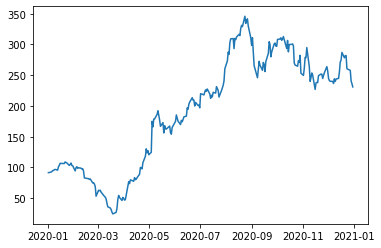

In [9]:
plt.plot(data_yh.Open)

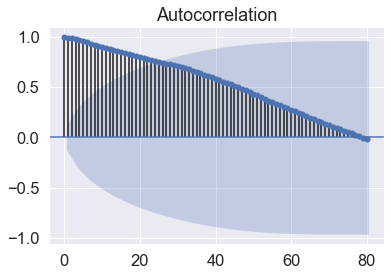

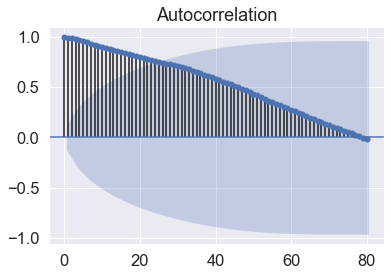

In [76]:
sm.graphics.tsa.plot_acf(data_yh.Open.squeeze(), lags=80)

In [10]:
data_yh.shape

(253, 6)

In [18]:
def window_shift(data, window, col):
    for i in range(1, window+1):
        col_new = '{col}_prev_{w}'.format(col=col, w=i)
        data[col_new] = data[col].shift(periods=i)
    
    df = data.dropna()
    print(df.shape)
    return df

In [20]:
df_yh = window_shift(data_yh, 3, 'Open')
df_yh.head()

,Open,High,Low,Close,Adj Close,Volume,Open_prev_1,Open_prev_2,Open_prev_3
Date,,,,,,,,,
2020-01-07,94.910004,96.580002,92.500000,95.699997,95.699997,1877400,93.019997,91.800003,91.629997
2020-01-08,95.139999,97.362999,94.489998,95.169998,95.169998,2251200,94.910004,93.019997,91.800003
2020-01-09,96.269997,97.199997,93.379997,96.750000,96.750000,1441000,95.139999,94.910004,93.019997
2020-01-10,96.910004,97.680000,94.510002,95.220001,95.220001,1932800,96.269997,95.139999,94.910004
2020-01-13,95.720001,102.080002,92.949997,101.000000,101.000000,3245500,96.910004,96.269997,95.139999


In [21]:
df_yh.shape

(250, 9)

In [36]:
cols = ['Open', 'Open_prev_1', 'Open_prev_2', 'Open_prev_3']

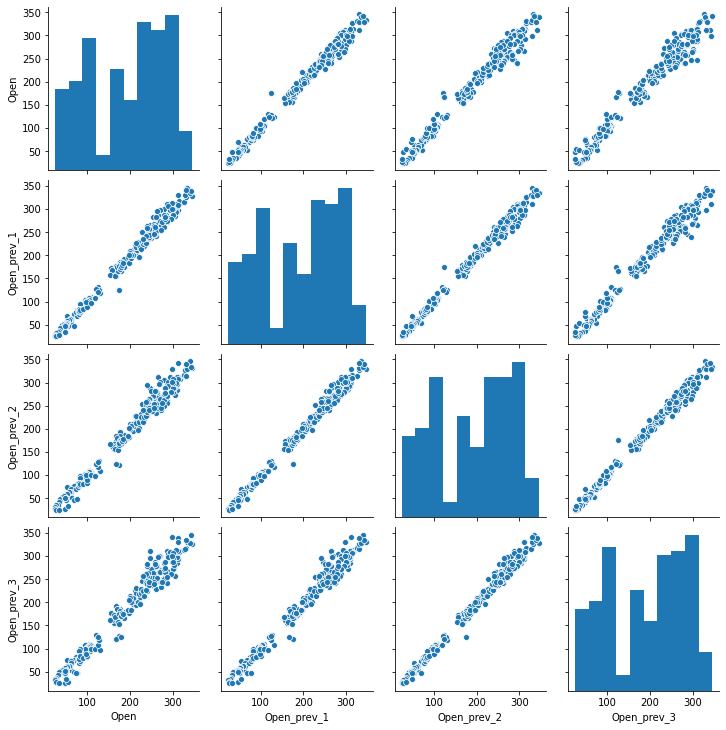

In [38]:
sns.pairplot(df_yh[cols])
plt.show()

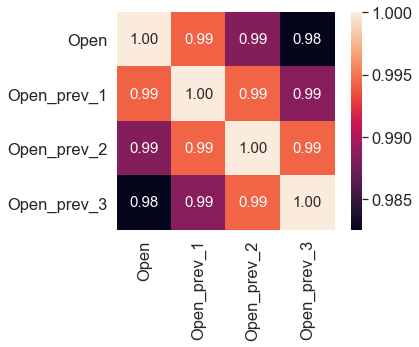

In [41]:
cm = np.corrcoef(df_yh[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.show()

In [29]:
def train_test_split(data, feature, label, train_size):
    n = data.shape[0]
    train_row = int(n*train_size)
    train_x = data.iloc[:train_row, :][feature]
    train_y = data.iloc[:train_row, :][label]
    
    test_x = data.iloc[train_row:, :][feature]
    test_y = data.iloc[train_row:, :][label]
    
    print('training data size: {}'.format(train_x.shape[0]))
    print('testing data size: {}'.format(test_x.shape[0]))
    
    return train_x, train_y, test_x, test_y

In [30]:
feature = ['Open_prev_1', 'Open_prev_2', 'Open_prev_3']
label = ['Open']
train_size=0.8
train_x, train_y, test_x, test_y = train_test_split(df_yh, feature, label, train_size)

training data size: 200
testing data size: 50


## Model fit - Linear Reg

In [43]:
lr = LinearRegression()

In [44]:
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
lr.coef_

array([[ 0.98430619,  0.04309846, -0.02977646]])

In [47]:
lr.intercept_

array([1.44115964])

In [48]:
predict_y = lr.predict(test_x)

In [71]:
predict_y.reshape(-1, 50).flatten()

array([301.67549574, 298.6074852 , 271.07775868, 266.57682072,
       265.42049233, 274.13918007, 272.09504662, 282.93462617,
       254.88676637, 249.75123118, 261.82058023, 279.88671454,
       279.80565445, 295.50634458, 265.71959488, 240.38669624,
       246.24546815, 254.60985584, 251.55408531, 228.06903591,
       237.64613395, 239.53340488, 238.89352999, 249.97862774,
       253.10447012, 252.68619671, 245.68825428, 254.50632916,
       264.95751303, 258.22262443, 245.81149629, 241.84112973,
       240.97506842, 240.83259458, 237.51890551, 244.87946294,
       241.07629555, 244.53240671, 245.8534947 , 256.12634778,
       272.53349806, 275.82415278, 287.79122487, 279.56141932,
       282.27323793, 282.88444498, 261.67487252, 258.12619627,
       241.67097778, 236.62657526])

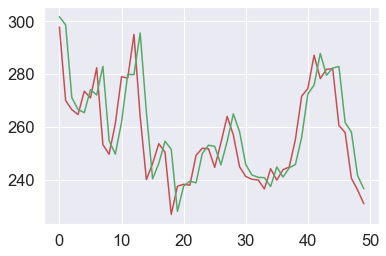

In [73]:
plt.plot(test_y.values, color='r')
plt.plot(predict_y.reshape(-1, 50).flatten(), color='g')

## Model fit -  NN

In [77]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation="linear")
])

In [82]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])
history = model.fit(train_x, train_y, epochs=500)

Epoch 1/500
7/7 [==============================] - 0s 1ms/step - loss: 5.9810 - mae: 6.4549
Epoch 2/500
7/7 [==============================] - 0s 1ms/step - loss: 5.9662 - mae: 6.4391
Epoch 3/500
7/7 [==============================] - 0s 996us/step - loss: 5.9685 - mae: 6.4409
Epoch 4/500
7/7 [==============================] - 0s 761us/step - loss: 5.9634 - mae: 6.4368
Epoch 5/500
7/7 [==============================] - 0s 937us/step - loss: 5.9638 - mae: 6.4369
Epoch 6/500
7/7 [==============================] - 0s 1ms/step - loss: 5.9615 - mae: 6.4360
Epoch 7/500
7/7 [==============================] - 0s 749us/step - loss: 5.9623 - mae: 6.4418
Epoch 8/500
7/7 [==============================] - 0s 799us/step - loss: 5.9677 - mae: 6.4479
Epoch 9/500
7/7 [==============================] - 0s 951us/step - loss: 5.9597 - mae: 6.4392
Epoch 10/500
7/7 [==============================] - 0s 954us/step - loss: 5.9647 - mae: 6.4379
Epoch 11/500
7/7 [==============================] - 0s 835us/step

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [84]:
print(model.layers[0].get_weights())

[array([[ 0.9239981 ],
       [ 0.12232696],
       [-0.04374113]], dtype=float32), array([-0.08083474], dtype=float32)]


In [86]:
pred_y=model.predict(test_x)

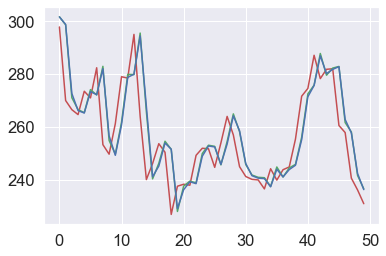

In [88]:
plt.plot(test_y.values, color='r')
plt.plot(predict_y.reshape(-1, 50).flatten(), color='g')
plt.plot(pred_y.reshape(-1, 50).flatten(), color='b')

In [96]:
a = predict_y.reshape(-1, 50).flatten()
b= test_y.values.reshape(-1, 50).flatten()
error = a-b

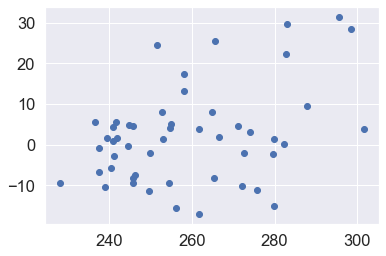

In [105]:
plt.scatter(a, error)

## Model fit - random forest

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
rf = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=2)

In [131]:
rf.fit(train_x.values, train_y.values.flatten())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [132]:
pred_y_rf = rf.predict(test_x.values)

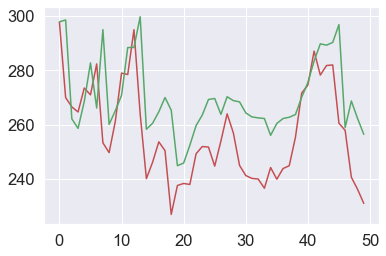

In [133]:
plt.plot(test_y.values, color='r')
plt.plot(pred_y_rf, color='g')

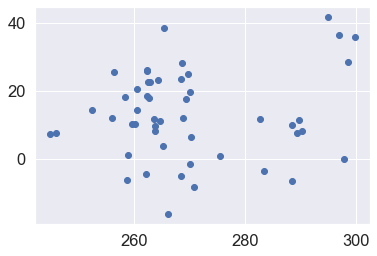

In [134]:
plt.scatter(pred_y_rf, pred_y_rf-test_y.values.reshape(-1, 50).flatten())

## Model fit - xgboost

In [138]:
from xgboost import XGBRegressor
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

In [139]:
param_dist = {
    'max_depth': range(3,15,2), ## maximum depth of a tree
    'min_child_weight': range(2, 20, 2),  ## minimum number of instances in each leaf node
    'learning_rate': stats.uniform(0.01, 0.3), ## step size shrinkage used in updates
    'n_estimators': range(30, 800, 20), ## number of gradient boosted trees
    'subsample': stats.uniform(0.6, 0.4), ## subsample ratio of the training instances for each boosted tree
    'colsample_bytree': stats.uniform(0.6, 0.4), ## subsample ratio of columns when construction each tree
    'gamma': stats.uniform(0.7, 0.3) ## minimum loss reduction required to make a further partion on a leaf node of the tree 
}


In [141]:
rs = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='hist', seed=1),
    param_distributions=param_dist,
    scoring='explained_variance',
    n_jobs=4,
    cv=5,
    verbose=1,
    n_iter=10,
    return_train_score=True
)
# tune the hyperparameter using RandomSearchCV
rs.fit(train_x.values, train_y.values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monot...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16b2c1320>,
                                        'max_depth': range(3, 15

In [143]:
model = rs.best_estimator_

In [144]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8997196737565364,
             enable_categorical=False, gamma=0.7625628537644219, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.10963138276938054, max_delta_step=0, max_depth=7,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=1, num_parallel_tree=1,
             objective='reg:squarederror', predictor='auto', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
             subsample=0.7964263902551492, tree_method='hist',
             validate_parameters=1, verbosity=None)

In [145]:
pred_y_xg = model.predict(test_x.values)

In [146]:
pred_y_xg

array([290.1686 , 290.1686 , 259.74884, 257.7853 , 260.0565 , 276.9422 ,
       260.49307, 276.9422 , 262.02002, 259.20724, 257.09094, 273.97665,
       280.4836 , 289.37097, 262.02002, 239.91173, 252.63205, 257.09094,
       257.09094, 229.68303, 224.78714, 234.23074, 234.23074, 252.10432,
       257.09094, 257.09094, 257.09094, 259.06052, 257.09094, 257.09094,
       258.52954, 259.06052, 241.18694, 234.23074, 234.23074, 252.10432,
       241.18694, 252.10432, 259.06052, 259.06052, 257.09094, 273.97665,
       280.54095, 282.01053, 281.1613 , 282.01053, 261.17078, 259.20724,
       239.21735, 234.23074], dtype=float32)

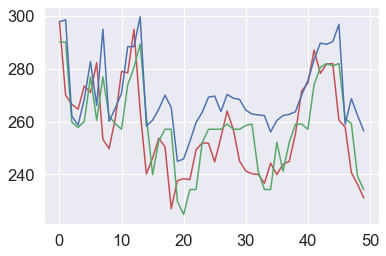

In [148]:
plt.plot(test_y.values, color='r')
plt.plot(pred_y_xg, color='g')
plt.plot(pred_y_rf, color='b')

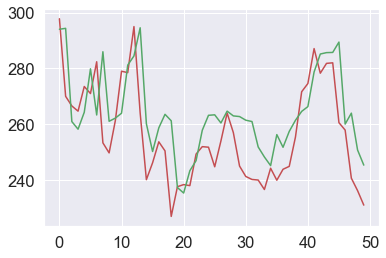

In [150]:
plt.plot(test_y.values, color='r')
plt.plot((pred_y_xg+pred_y_rf)/2, color='g')